# Complete guide to Machine Learning with H2O (AutoML)

In this notebook, we use the subset of the loan-level dataset from Fannie Mae and Freddie Mac. Firstly, we will solve a binary classification problem (predicting if a loan is delinquent or not). Then, we will explore a regression use-case (predicting interest rates on the same dataset). We will try to do both use-cases using Automatic Machine Learning (AutoML), and we will do so using the H2O-3 Python module in a Jupyter Notebook and also in Flow.

We will use H2O AutoML to make below predictions:

- Predict whether a mortgage loan will be delinquent or not
- Predict the interest rate for each loan

## AutoML Concepts

### AutoML
Choosing the best machine learning models and tuning them can be time consuming and exhaustive. Often, it requires levels of expertise to know what parameters to tune. The field of AutoML focuses on solving this issue. AutoML is useful both for experts, by automating the process of choosing and tuning a model; and for non-experts as well, by helping them to create high performing models in a short time frame. Some of the aspects of machine learning that can be automated include data preparation, which can include imputation, one-hot encoding, feature selection/extraction, and also feature engineering. Another aspect that can be automated is the model generation, which includes training a model and tuning it with cartesian or random grid search. Lastly, a third aspect that could be using ensembles, as they usually outperform individual models.

H2O AutoML is an automated algorithm for automating the machine learning workflow, which includes some light data preparation such as imputing missing data, standardization of numeric features, and one-hot encoding categorical features. It also provides automatic training, hyper-parameter optimization, model search, and selection under time, space, and resource constraints. H2O's AutoML further optimizes model performance by stacking an ensemble of models. H2O AutoML trains one stacked ensemble based on all previously trained models and another one on the best model of each family.

The current version of AutoML trains and cross-validates the following model: GLMs, a Random Forest, an Extremely-Randomized Forest, a random grid of Gradient Boosting Machines (GBMs), XGBoosts, a random grid of Deep Neural Nets, and a Stacked Ensemble of all the models. If you would like to know more details about the models trained by AutoML, please visit Which models are trained in the AutoML process? under the FAQ of the AutoML Documentation section.
To see how H2O AutoML performs compared to other AutoML algorithms, please look at An Open Source AutoML Benchmark

### Stacked Ensembles
Ensemble machine learning methods use multiple learning algorithms to obtain better predictive performance than the ones that could be obtained from any of the constituent learning algorithms. Many of the popular modern machine learning algorithms are actually ensembles. For example, Random Forest and Gradient Boosting Machine (GBM) are both ensemble learners. Both bagging (e.g., Random Forest) and boosting (e.g., GBM) are methods for ensembling that take a collection of weak learners (e.g., decision tree) and form a single, strong learner.

H2O's Stacked Ensemble method is a supervised ensemble machine learning algorithm that finds the optimal combination of a collection of prediction algorithms using a process called stacking. Like all supervised models in H2O, Stacked Ensemble supports regression, binary classification, and multiclass classification. If you would like to know more, make sure to check the Stacked Ensemble Section in the H2O-3 Documentation.

In [2]:
import h2o
import matplotlib as plt
%matplotlib inline
from h2o.automl import H2OAutoML

In [3]:
import os
import h2o

startup  = '/home/h2o/bin/aquarium_startup'
shutdown = '/home/h2o/bin/aquarium_stop'

if os.path.exists(startup):
    os.system(startup)
    local_url = 'http://localhost:54321/h2o'
    aquarium = True
else:
    local_url = 'http://localhost:54321'
    aquarium = False

In [4]:
h2o.init(url=local_url)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\bokhy\AppData\Local\Temp\tmp9syxelmf
  JVM stdout: C:\Users\bokhy\AppData\Local\Temp\tmp9syxelmf\h2o_bokhy_started_from_python.out
  JVM stderr: C:\Users\bokhy\AppData\Local\Temp\tmp9syxelmf\h2o_bokhy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_bokhy_ughxpn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.524 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


### 1. Let's import the dataset.

In [5]:
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/H2O-3-Tutorials/loan_level_50k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE
730,199903,N,202902,16620,30,1,O,94,29,138000,94,7,T,N,FRM,WV,SF,25300,F199Q1000037,P,360,2,Other sellers,Other servicers,TRUE,FALSE
638,199905,N,202904,42020,nan,1,O,67,28,160000,67,7.375,T,N,FRM,CA,SF,93400,F199Q1000067,N,360,2,CROSSLAND MORTGAGE C,CHASEMTGECO,TRUE,FALSE
577,199903,N,202902,12580,12,1,O,80,53,43000,80,7.25,T,N,FRM,MD,SF,21200,F199Q1000086,N,360,1,ACCUBANC MORTGAGE CO,GMACMTGECORP,FALSE,TRUE
693,199905,N,202904,nan,nan,1,O,80,43,93000,80,7.125,R,N,FRM,SD,SF,57500,F199Q1000104,P,360,1,"NORWEST MORTGAGE, IN",WELLSFARGOHOMEMORTGA,TRUE,FALSE
739,199905,,202904,16700,nan,1,S,80,25,200000,80,6.875,R,N,FRM,SC,CO,29400,F199Q1000107,P,360,2,"NORWEST MORTGAGE, IN",WELLSFARGOHOMEMORTGA,TRUE,FALSE
695,199905,,202904,42044,0,1,O,40,6,135000,40,6.875,R,N,FRM,CA,SF,92800,F199Q1000121,C,360,2,NATIONSBANC MORTGAGE,"BAMORTGAGE,LLC",TRUE,FALSE
753,199905,N,202904,41740,0,1,O,80,17,59000,80,7,R,N,FRM,CA,CO,92000,F199Q1000122,P,360,1,NATIONSBANC MORTGAGE,"BAMORTGAGE,LLC",TRUE,FALSE
712,199905,,202904,nan,nan,1,O,80,28,126000,80,7.125,R,N,FRM,MI,SF,48800,F199Q1000123,N,360,2,Other sellers,Other servicers,TRUE,FALSE


In [8]:
loan_level.describe()

Rows:49930
Cols:27




,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
type,int,int,enum,int,int,int,int,enum,int,int,int,int,real,enum,enum,enum,enum,enum,int,string,enum,int,int,enum,enum,enum,enum
mins,300.0,199902.0,,202404.0,10180.0,0.0,1.0,,6.0,1.0,10000.0,6.0,5.0,,,,,,600.0,NaN,,301.0,1.0,,,,
mean,712.306600068478,200025.6742239135,,203023.3970759063,30705.25866529918,7.719609503855925,1.0281994792709794,,76.08864765261977,32.83933763635988,136369.67754856797,75.74523823829837,7.185977708792309,,,,,,55401.43412250129,NaN,,359.8508311636291,1.629450778447913,,,,
maxs,830.0,200403.0,,203312.0,49740.0,50.0,4.0,,160.0,65.0,529000.0,100.0,10.625,,,,,,99900.0,NaN,,361.0,2.0,,,,
sigma,54.97355321804359,109.77460105156621,,110.47953133306562,11363.124822676407,12.042273590466618,0.219623303648194,,15.06208012347409,11.165383364972824,60632.743281235904,14.86722833135055,0.5835949914330256,,,,,,29512.322859225387,NaN,,1.9974697613404848,0.48295669536262237,,,,
zeros,0,0,,0,0,31023,0,,0,0,0,0,0,,,,,,0,0,,0,0,,,,
missing,279,0,13067,0,7029,5064,0,0,2,1437,0,1,0,0,504,0,0,13,4,0,0,0,23,0,0,0,0
0,707.0,200211.0,N,202903.0,33340.0,0.0,1.0,O,60.0,57.0,136000.0,60.0,6.25,R,N,FRM,WI,SF,53000.0,F199Q1000018,C,317.0,2.0,Other sellers,Other servicers,TRUE,FALSE
1,691.0,200302.0,N,202901.0,15940.0,0.0,1.0,O,65.0,25.0,130000.0,65.0,5.875,R,N,FRM,OH,SF,44700.0,F199Q1000023,P,312.0,2.0,Other sellers,Other servicers,TRUE,FALSE
2,730.0,199903.0,N,202902.0,16620.0,30.0,1.0,O,94.0,29.0,138000.0,94.0,7.0,T,N,FRM,WV,SF,25300.0,F199Q1000037,P,360.0,2.0,Other sellers,Other servicers,TRUE,FALSE


Let's take a look at the **DELINQUENT**, which is the response of our classification problem.

In [9]:
loan_level["DELINQUENT"].table()

DELINQUENT,Count
FALSE,48118
TRUE,1812


As we saw in the classification tutorial, the dataset is highly imbalanced, which is the same scenario in this case.

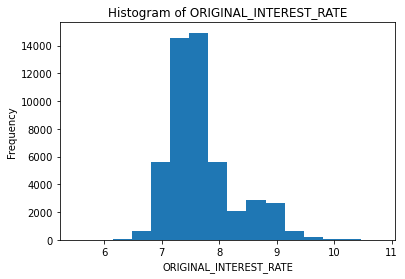

In [10]:
loan_level["ORIGINAL_INTEREST_RATE"].hist()

Again, we see that the average interest rate ranges from 7% to 8%, similar to what we saw in the previous tutorial.

Now that we have an idea of the distribution of the responses let's split the dataset. For this tutorial, we will take a slightly different approach. Instead of splitting the dataset into three sets, we are just going to do 2, a train and test set. We will be using cross-validation to validate our models, as we need to use the k-fold cross-validation in order to get the stacked ensembles from the AutoML.

In [11]:
train, test = loan_level.split_frame([0.8], seed=623)

In [12]:
print("train:%d test:%d" % (train.nrows, test.nrows))

train:39988 test:9942


### 2. H2O AutoML Classification Problem

We already have our train and test sets, so we just need to choose our response variable, as well as the predictors

In [13]:
y = "DELINQUENT"
ignore = ["DELINQUENT", "PREPAID", "PREPAYMENT_PENALTY_MORTGAGE_FLAG", "PRODUCT_TYPE"] 
x = list(set(train.names) - set(ignore))

##### Default parameters

In [14]:
H2OAutoML(nfolds=5, max_runtime_secs=3600, max_models=None, stopping_metric='AUTO', stopping_tolerance=None, stopping_rounds=3, seed=None, project_name=None)

As you can see, H2O AutoML is designed to have as few parameters as possible, which makes it very easy to use. For this experiment, we could've just changed the maximum runtime, the seed, and the project name; however, from our first tutorial, we learned that our dataset is highly imbalanced and that models have a hard time classifying the minority class. For that reason, we are setting balance_classes=True, and we are setting the sampling factors to [0.5,1.25], which means that we will undersample the majority class, and oversample the minority class. Also, we will set max_models = 25 and to make sure that AutoML trains all 25 models in less than 20 min, we will also set max_runtime_secs_per_model=30 which will make sure no model takes more than 30 seconds to be trained.

##### Run AutoML with tuned parameters

In [15]:
aml = H2OAutoML(max_models=25, max_runtime_secs_per_model=30, seed=623, project_name='classification', 
                balance_classes=True, class_sampling_factors=[0.5,1.25])
%time aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
13:55:38.974: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%
Wall time: 10min 52s


The only required parameters for H2O's AutoML are, y, training_frame, and max_runtime_secs, which let us train AutoML for ‘x' amount of seconds and/or max_models, which would train a maximum number of models. Please note that max_runtime_secs has a default value, while max_models does not. For this task, we will set a number of models constraint. The seed is the usual parameter that we set for reproducibility purposes. We also need a project name because we will do both classification and regression with AutoML. Lastly, we are setting balance_classes=True because we have a very imbalanced dataset, and we are using the default number of folds for cross-validation.

The second line of code has the parameters that we need in order to train our model. For now, we will just pass x, y, and the training frame. Please note that the parameter x is optional because if you were using all the columns in your dataset, you would not need to declare this parameter. The leaderboard frame can be used to score and rank models on the leaderboard, but we will use the validation scores to do so because we will check the performance of our models with the test set.

Below is a list of optional parameters that the user could set for H2O's AutoML

validation_frame
leaderboard_frame
blending_frame
fold_column
weights_column
ignored_columns
class_sampling_factors
max_after_balance_size
max_runtime_secs_per_model
sort_metric
exclude_algos
include_algos
keep_cross_validation_predictions
keep_cross_validation_models
keep_cross_validation_fold_assignment
verbosity
export_checkpoints_dir

#### Check the result

In [16]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200812_135538,0.85201,0.128657,0.215807,0.331493,0.178643,0.0319133
StackedEnsemble_BestOfFamily_AutoML_20200812_135538,0.849861,0.128865,0.213184,0.326066,0.178739,0.0319478
GLM_1_AutoML_20200812_135538,0.848744,0.123718,0.198831,0.346984,0.177685,0.0315718
GBM_grid__1_AutoML_20200812_135538_model_8,0.842631,0.124233,0.208981,0.352758,0.176972,0.0313192
GBM_grid__1_AutoML_20200812_135538_model_7,0.840089,0.126531,0.195402,0.359213,0.178401,0.0318268
DeepLearning_grid__2_AutoML_20200812_135538_model_3,0.837065,0.129292,0.192153,0.326679,0.179043,0.0320564
DeepLearning_1_AutoML_20200812_135538,0.835925,0.127474,0.188773,0.341284,0.17856,0.0318837
GBM_1_AutoML_20200812_135538,0.835779,0.127302,0.190028,0.328931,0.178697,0.0319328
GBM_2_AutoML_20200812_135538,0.833233,0.129255,0.180142,0.334563,0.179695,0.0322902
GBM_grid__1_AutoML_20200812_135538_model_6,0.832383,0.127926,0.183574,0.35257,0.179044,0.0320568


##### We can also print a leaderboard with the training time, in milliseconds, of each model and the time it takes each model to predict each row, in milliseconds:

In [17]:
from h2o.automl import get_leaderboard
lb2 = get_leaderboard(aml, extra_columns='ALL')
lb2.head(rows=lb2.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20200812_135538,0.85201,0.128657,0.215807,0.331493,0.178643,0.0319133,5830,0.081064
StackedEnsemble_BestOfFamily_AutoML_20200812_135538,0.849861,0.128865,0.213184,0.326066,0.178739,0.0319478,1308,0.022333
GLM_1_AutoML_20200812_135538,0.848744,0.123718,0.198831,0.346984,0.177685,0.0315718,822,0.001128
GBM_grid__1_AutoML_20200812_135538_model_8,0.842631,0.124233,0.208981,0.352758,0.176972,0.0313192,838,0.005632
GBM_grid__1_AutoML_20200812_135538_model_7,0.840089,0.126531,0.195402,0.359213,0.178401,0.0318268,728,0.004074
DeepLearning_grid__2_AutoML_20200812_135538_model_3,0.837065,0.129292,0.192153,0.326679,0.179043,0.0320564,1236,0.00342
DeepLearning_1_AutoML_20200812_135538,0.835925,0.127474,0.188773,0.341284,0.17856,0.0318837,1208,0.002086
GBM_1_AutoML_20200812_135538,0.835779,0.127302,0.190028,0.328931,0.178697,0.0319328,1601,0.003713
GBM_2_AutoML_20200812_135538,0.833233,0.129255,0.180142,0.334563,0.179695,0.0322902,1095,0.003822
GBM_grid__1_AutoML_20200812_135538_model_6,0.832383,0.127926,0.183574,0.35257,0.179044,0.0320568,893,0.004512


By looking at the leaderboard, we can see that the best model is the Stacked Ensemble with the best model from each family, meaning that this model was built using the best model of each of the trained algorithms. This Ensemble will usually have a GLM, a Distributed Random Forest, Extremely-Randomized Forest, a GBM, and XGBoost, and Deep Learning model if you give it enough time to train all those models. Let's explore the coefficients of the metalearner to see the models in the Stacked Ensemble with their relative importance.

First, let's retrieve the metalearner, and we can do it as follow:

In [18]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_BestOfFamily" in mid][0])

# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])
metalearner.coef()

{'Intercept': -4.180033392203896,
 'GLM_1_AutoML_20200812_135538': 0.0,
 'GBM_grid__1_AutoML_20200812_135538_model_8': 0.5416148940934792,
 'DeepLearning_grid__2_AutoML_20200812_135538_model_3': 5.450841491109107,
 'DRF_1_AutoML_20200812_135538': 4.046221096033774,
 'XRT_1_AutoML_20200812_135538': 3.17959412522165}

If you wanted to check this for the Ensemble with all the models, you will just simply change the name **StackedEnsemble_BestOfFamily** to **StackedEnsemble_AllModels** when saving the se variable in the code above.

From the list above, we can see that the most important model used in our Stacked Ensemble is an XRT(Extremely Randomized Tree model, which is a variation of random forest). We can also plot the standardized coefficients with the following code (assuming you retrieved the metalearner from the step above):

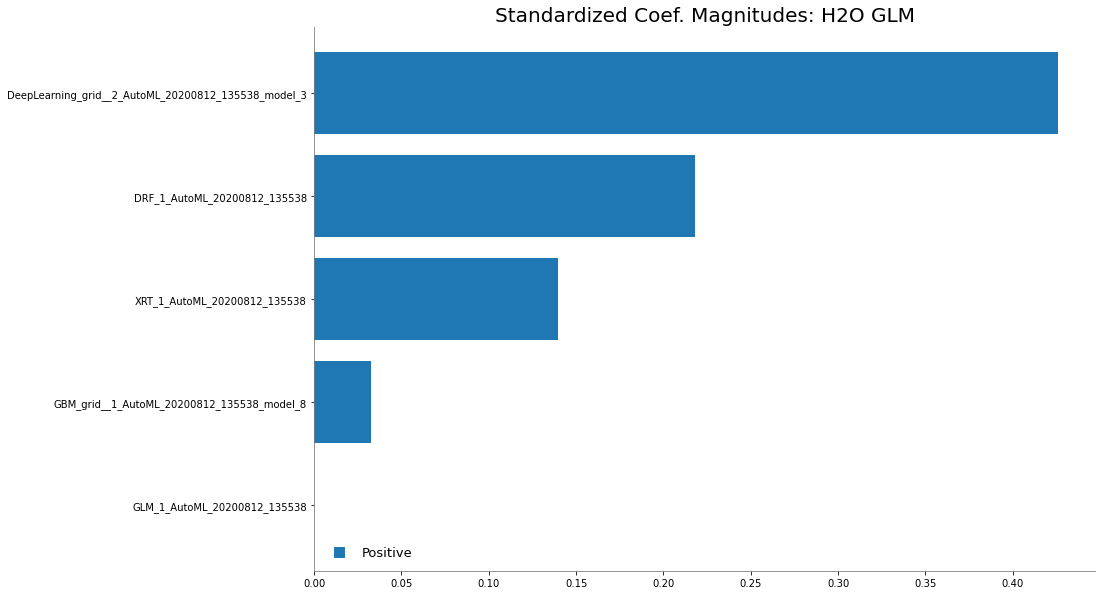

In [19]:
metalearner.std_coef_plot()

Now, let's see how the best model performs on our test set.

In [20]:
aml.leader.model_performance(test_data=test)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.032409928215075774
RMSE: 0.18002757626284863
LogLoss: 0.1323640249003153
Null degrees of freedom: 9941
Residual degrees of freedom: 9933
Null deviance: 3161.788933631878
Residual deviance: 2631.92627111787
AIC: 2649.92627111787
AUC: 0.8443999107757988
AUCPR: 0.23988545454219756
Gini: 0.6887998215515976

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0700597907128049: 


,,FALSE,TRUE,Error,Rate
0,FALSE,9142.0,430.0,0.0449,(430.0/9572.0)
1,TRUE,220.0,150.0,0.5946,(220.0/370.0)
2,Total,9362.0,580.0,0.0654,(650.0/9942.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.070060,0.315789,230.0
1,max f2,0.031562,0.388334,313.0
2,max f0point5,0.160633,0.315871,147.0
3,max accuracy,0.663143,0.963891,21.0
4,max precision,0.881434,0.833333,5.0
5,max recall,0.015219,1.000000,398.0
6,max specificity,0.981817,0.999896,0.0
7,max absolute_mcc,0.070060,0.291131,230.0
8,max min_per_class_accuracy,0.025020,0.765253,337.0
9,max mean_per_class_accuracy,0.025485,0.767782,335.0



Gains/Lift Table: Avg response rate:  3.72 %, avg score:  3.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010058,0.319650,11.554216,11.554216,0.430000,0.548551,0.430000,0.548551,0.116216,0.116216,1055.421622,1055.421622,0.110261
1,2,0.020016,0.184518,7.599672,9.586880,0.282828,0.239019,0.356784,0.394563,0.075676,0.191892,659.967240,858.688035,0.178520
2,3,0.030074,0.128113,5.642757,8.267775,0.210000,0.153236,0.307692,0.313852,0.056757,0.248649,464.275676,726.777547,0.227023
3,4,0.040032,0.095541,4.342670,7.291430,0.161616,0.111045,0.271357,0.263405,0.043243,0.291892,334.266994,629.143012,0.261595
4,5,0.050091,0.080742,6.717568,7.176197,0.250000,0.087652,0.267068,0.228113,0.067568,0.359459,571.756757,617.619668,0.321327
5,6,0.100080,0.045972,2.757311,4.968975,0.102616,0.059070,0.184925,0.143676,0.137838,0.497297,175.731144,396.897460,0.412571
6,7,0.150070,0.034969,2.432922,4.124190,0.090543,0.039903,0.153485,0.109108,0.121622,0.618919,143.292186,312.419028,0.486972
7,8,0.200060,0.028667,1.892273,3.566491,0.070423,0.031431,0.132730,0.089699,0.094595,0.713514,89.227255,256.649138,0.533300
8,9,0.300040,0.022684,0.946136,2.693332,0.035211,0.025304,0.100235,0.068241,0.094595,0.808108,-5.386372,169.333249,0.527707
9,10,0.400020,0.019795,0.756909,2.209348,0.028169,0.021102,0.082223,0.056459,0.075676,0.883784,-24.309098,120.934835,0.502463


By looking at the results, we can see that in fifteen minutes, and with less data, AutoML obtained scores somewhat close to what we obtained in the first tutorial. The AUC that we obtained was 0.828. Although this is a good AUC, because we have a very imbalanced dataset, we must also look at the misclassification errors for both classes. As you can see, our model is having a hard time classifying bad loans; this is mainly due because only about 3.6% of loans are labeled as bad loans. However, the model is doing very well when classifying good loans; although it is still far from being the best model, this gives us a solid starting point. Even though we set balance _lasses=True, we just tried a quick under-over sampling ratio. If we were to find the right value and gave AutoML more time, we could potentially improve the misclassification error for the bad_loan or predicted TRUE class.

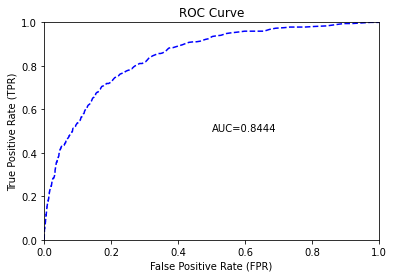

In [21]:
%matplotlib inline
aml.leader.model_performance(test_data=test).plot()

As you can see, it's the same AUC value that we obtained in the model summary, but the plot helps us visualize it better.

Lastly, let's make some predictions on our test set.

In [22]:
aml.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,FALSE,TRUE
FALSE,0.983562,0.0164383
FALSE,0.960454,0.039546
FALSE,0.979351,0.0206494
FALSE,0.977953,0.0220471
FALSE,0.963207,0.0367931
FALSE,0.980323,0.0196766
FALSE,0.984581,0.0154186
FALSE,0.983023,0.0169775
TRUE,0.768001,0.231999
FALSE,0.984178,0.0158217


As we mentioned in the first tutorial, the predictions we get are based on a probability. In the frame above, we have a probability for FALSE,, and another one for TRUE. The prediction, predict, is based on the threshold that maximizes the F1 score. For example, the threshold that maximizes the F1 is about 0.1061, meaning that if the probability of TRUE is greater than the threshold, the predicted label would be TRUE.

After exploring the results for our classification problem, let's use AutoML to explore a regression use-case.

### 3. H2O AutoML Regression Problem

For our regression use-case, we are using the same dataset and the same training and test sets. But we do need to choose our predictors and response columns, and we will do it as follow:

In [23]:
y_reg = "ORIGINAL_INTEREST_RATE"

ignore_reg = ["ORIGINAL_INTEREST_RATE", "FIRST_PAYMENT_DATE", "MATURITY_DATE", "MORTGAGE_INSURANCE_PERCENTAGE", "PREPAYMENT_PENALTY_MORTGAGE_FLAG", "LOAN_SEQUENCE_NUMBER", "PREPAID", "DELINQUENT", "PRODUCT_TYPE"] 

x_reg = list(set(train.names) - set(ignore_reg))

Now we are ready to start our second AutoML model and train it. This time we will use a time constrain, and set max_runtime_secs to 900 seconds, or 15 minutes. Again, we set max_runtime_secs_per_model to 30 seconds. You will notice that we are specifying the stopping metric and also the sort metric. In the second tutorial, we focused on RMSE and MAE to check the performance of our model, and we noticed that the two values seemed very correlated. For that reason, we could use any of those metrics. We will use the RMSE for early stopping because it penalizes the error more than the MAE, and we will also use it to sort the leaderboard based on the best value.

In [24]:
aml = H2OAutoML(max_runtime_secs=900, 
                max_runtime_secs_per_model=30, 
                seed=623, 
                project_name='regression', 
                stopping_metric="RMSE", 
                sort_metric="RMSE")

%time 
aml.train(x=x_reg, y=y_reg, training_frame=train)

Wall time: 0 ns
AutoML progress: |
14:29:11.802: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [25]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
GBM_2_AutoML_20200812_142911,0.428265,0.183411,0.183411,0.311863,0.0506688
GBM_grid__1_AutoML_20200812_142911_model_8,0.428337,0.183473,0.183473,0.311138,0.050679
GBM_3_AutoML_20200812_142911,0.428621,0.183716,0.183716,0.311637,0.0506949
GBM_5_AutoML_20200812_142911,0.429201,0.184213,0.184213,0.313097,0.0508055
GBM_1_AutoML_20200812_142911,0.429429,0.184409,0.184409,0.313175,0.0508044
GBM_grid__1_AutoML_20200812_142911_model_7,0.429573,0.184533,0.184533,0.313894,0.0508162
GBM_4_AutoML_20200812_142911,0.430283,0.185144,0.185144,0.313212,0.0508986
GBM_grid__1_AutoML_20200812_142911_model_6,0.430743,0.185539,0.185539,0.315183,0.0509298
GBM_grid__1_AutoML_20200812_142911_model_1,0.430833,0.185617,0.185617,0.312861,0.0509754
GBM_grid__1_AutoML_20200812_142911_model_3,0.431312,0.18603,0.18603,0.312872,0.051025


The leaderboard shows that the GBM models clearly dominated this task. We can retrieve the best model with the model.leader command; but, what if we wanted to get another model from our leaderboard? One way to do so is shown below:

In [26]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

# Get the top GBM model
gbm = h2o.get_model([mid for mid in model_ids if "GBM_3" in mid][0])

In [28]:
model_ids

['GBM_2_AutoML_20200812_142911',
 'GBM_grid__1_AutoML_20200812_142911_model_8',
 'GBM_3_AutoML_20200812_142911',
 'GBM_5_AutoML_20200812_142911',
 'GBM_1_AutoML_20200812_142911',
 'GBM_grid__1_AutoML_20200812_142911_model_7',
 'GBM_4_AutoML_20200812_142911',
 'GBM_grid__1_AutoML_20200812_142911_model_6',
 'GBM_grid__1_AutoML_20200812_142911_model_1',
 'GBM_grid__1_AutoML_20200812_142911_model_3',
 'GBM_grid__1_AutoML_20200812_142911_model_4',
 'StackedEnsemble_AllModels_AutoML_20200812_142911',
 'DRF_1_AutoML_20200812_142911',
 'StackedEnsemble_BestOfFamily_AutoML_20200812_142911',
 'GBM_grid__1_AutoML_20200812_142911_model_2',
 'GBM_grid__1_AutoML_20200812_142911_model_5',
 'GLM_1_AutoML_20200812_142911',
 'XRT_1_AutoML_20200812_142911',
 'DeepLearning_1_AutoML_20200812_142911',
 'DeepLearning_grid__1_AutoML_20200812_142911_model_1',
 'DeepLearning_grid__1_AutoML_20200812_142911_model_4',
 'DeepLearning_grid__1_AutoML_20200812_142911_model_3',
 'DeepLearning_grid__3_AutoML_20200812_14

Note that you would need to change the name **GBM_3**, in the code above, to the name of the model that you want, and that should retrieve the desired model. For example, if you wanted to get the best XGBoost in the leaderboard, you would need to make the following change (you do not need to run the following line of code, this is just an example)

In [29]:
xgb = h2o.get_model([mid for mid in model_ids if "StackedEnsemble" in mid][0])

Now that we have retrieved the best model, we can take a look at some of the parameters

In [30]:
print("ntrees = ", gbm.params['ntrees'])
print("max depth = ", gbm.params['max_depth'])
print("learn rate = ", gbm.params['learn_rate'])
print("sample rate = ", gbm.params['sample_rate'])

ntrees =  {'default': 50, 'actual': 64, 'input': 10000}
max depth =  {'default': 5, 'actual': 8, 'input': 8}
learn rate =  {'default': 0.1, 'actual': 0.1, 'input': 0.1}
sample rate =  {'default': 1.0, 'actual': 0.8, 'input': 0.8}


##### Check Model Summary

In [31]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20200812_142911


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,64.0,64.0,156285.0,8.0,8.0,8.0,58.0,214.0,148.82812




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.13595945090894726
RMSE: 0.3687267971126417
MAE: 0.2669786134576564
RMSLE: 0.0437219571364214
Mean Residual Deviance: 0.13595945090894726

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.1837159842191993
RMSE: 0.4286210263381853
MAE: 0.31163694450398555
RMSLE: 0.0506949417738023
Mean Residual Deviance: 0.1837159842191993

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.31163692,7.7659625E-4,0.31149286,0.3129312,0.31112084,0.31096697,0.31167278
1,mean_residual_deviance,0.18371594,0.0015572766,0.18277213,0.1861775,0.18369487,0.18206488,0.18387036
2,mse,0.18371594,0.0015572766,0.18277213,0.1861775,0.18369487,0.18206488,0.18387036
3,r2,0.4609645,0.0056585274,0.46189997,0.45222977,0.46615866,0.46547118,0.45906293
4,residual_deviance,0.18371594,0.0015572766,0.18277213,0.1861775,0.18369487,0.18206488,0.18387036
5,rmse,0.42861792,0.0018142059,0.42751858,0.4314829,0.4285964,0.4266906,0.42880106
6,rmsle,0.050694704,1.7132562E-4,0.05055868,0.050952785,0.05077792,0.050545648,0.050638497



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-08-12 14:30:15,15.915 sec,0.0,0.583814,0.441436,0.340839
1,,2020-08-12 14:30:15,16.079 sec,5.0,0.504835,0.380336,0.254859
2,,2020-08-12 14:30:15,16.242 sec,10.0,0.463384,0.346920,0.214725
3,,2020-08-12 14:30:15,16.400 sec,15.0,0.436223,0.323910,0.190291
4,,2020-08-12 14:30:15,16.557 sec,20.0,0.418665,0.308798,0.175280
5,,2020-08-12 14:30:15,16.706 sec,25.0,0.406488,0.298305,0.165232
6,,2020-08-12 14:30:16,16.854 sec,30.0,0.397875,0.290840,0.158305
7,,2020-08-12 14:30:16,17.006 sec,35.0,0.391741,0.285448,0.153461
8,,2020-08-12 14:30:16,17.158 sec,40.0,0.386023,0.280814,0.149013
9,,2020-08-12 14:30:16,17.314 sec,45.0,0.381194,0.276746,0.145309



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,SELLER_NAME,18106.402344,1.000000,0.467267
1,PROPERTY_STATE,5545.574707,0.306277,0.143113
2,SERVICER_NAME,3761.724121,0.207757,0.097078
3,ORIGINAL_UPB,1982.089600,0.109469,0.051151
4,OCCUPANCY_STATUS,1831.757690,0.101166,0.047272
5,LOAN_PURPOSE,1521.354492,0.084023,0.039261
6,CREDIT_SCORE,1431.580322,0.079065,0.036944
7,ORIGINAL_LOAN_TO_VALUE,1268.270874,0.070045,0.032730
8,ORIGINAL_DEBT_TO_INCOME_RATIO,862.028625,0.047609,0.022246
9,ORIGINAL_COMBINED_LOAN_TO_VALUE,591.995483,0.032695,0.015277


In the model summary above, we can see some of the parameters of our model, the metrics on the training data, and also the metrics from the cross-validation, as well as a detailed cross-validation metrics summary. We can also look at scoring history. However, by looking at the RMSE and MAE in the picture above for both training and validation, we can see that the model was starting to overfit because the training error is much lower than the validation error. Lastly, we can see the variable importance table, which shows both relative_importance, as well as scaled_importance, and also the percentage. For this model, the most important variable is SELLER_NAME, meaning that for our model, knowing which bank is providing the loan is very important.

Now, let's see how the leader from our AutoML performs on our test set.

In [32]:
gbm.model_performance(test_data=test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.18540924178823603
RMSE: 0.4305917344634428
MAE: 0.3115532061819847
RMSLE: 0.051014510155050576
Mean Residual Deviance: 0.18540924178823603


In case you had retrieved a different model other than the leader, and you actually wanted to check the performance of the best model in the leaderboard, you can do the following:

In [33]:
aml.leader.model_performance(test_data=test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.18459726887069192
RMSE: 0.42964784285585783
MAE: 0.3116065709311251
RMSLE: 0.05090685183518999
Mean Residual Deviance: 0.18459726887069192


We can see that the test RMSE and MAE, 0.4289 and 0.3132 respectively, are very close to the validation RMSE and MAE, 0.4309 and 0.3127, which shows us that doing 5-fold cross-validation gives us a good estimation of the error on unseen data.

Now, let's make some predictions on our test set.

In [34]:
pred = gbm.predict(test)
pred = pred.cbind(test['ORIGINAL_INTEREST_RATE'])
pred.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,ORIGINAL_INTEREST_RATE
7.0538,7
7.34609,7.15
6.8593,6.875
7.1055,7
7.17164,6.5
7.04135,6.625
6.85598,6.5
7.23544,7.25
7.06726,6.875
6.95089,6.875


Please note that we just combined the response column from our test frame to our predictions to see how the predictions compare to the actual value.

Out of the first ten predictions, most of them are very close to the actual values, with the exception of some predictions, such as the seventh prediction, which is 6.89, compared to the actual value which is 8.75. Because the RMSE is higher than the MAE, we can deduce that we have a couple of instances similar to the one mentioned above, because the larger errors are penalized more.

### 4. Shutdown the cluster

In [35]:
h2o.cluster().shutdown()